In [1]:
#initial version
#created on 24.11.2020
#Idea to train and predict every SOURCE_KEY separately
#Inspired by https://www.kaggle.com/furiousx7/xgboost-time-series
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold


train_data = pd.read_csv('../Data/Train_Plant2.csv')



In [2]:
def create_features(in_data):
    in_data['DATE_TIME'] = pd.to_datetime(in_data['DATE_TIME'])
    in_data["DATE"] = in_data['DATE_TIME'].dt.date
    in_data["HOUR"] = in_data['DATE_TIME'].dt.hour
    in_data["MINUTE"] = in_data['DATE_TIME'].dt.minute
    in_data["DAY_OF_YEAR"] = in_data['DATE_TIME'].dt.dayofyear
    in_data["DAY_OF_WEEK"] = in_data['DATE_TIME'].dt.dayofweek
    in_data["MONTH"] = in_data['DATE_TIME'].dt.month
    in_data["DAY_OF_MONTH"] = in_data['DATE_TIME'].dt.day

In [3]:
#Create separate training dataframe for each SOURCE_KEY
create_features(train_data)
split_date = pd.to_datetime('06-01-2020')
pred_train = train_data.loc[train_data.DATE <= split_date].copy()
pred_test = train_data.loc[train_data.DATE > split_date].copy()

unique_source_keys = train_data.SOURCE_KEY.unique()
trainSourceKeyDataFrames = [pred_train[pred_train.SOURCE_KEY == t] for t in unique_source_keys]
validSourceKeyDataFrames = [pred_test[pred_test.SOURCE_KEY == t] for t in unique_source_keys]

In [4]:
train_columns = ['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
#grouped_data = train_data.groupby(train_columns)[['DC_POWER','AC_POWER']].agg({'DC_POWER':'sum','AC_POWER':'sum'}).reset_index()
#print( pred_train.shape,pred_test.shape)

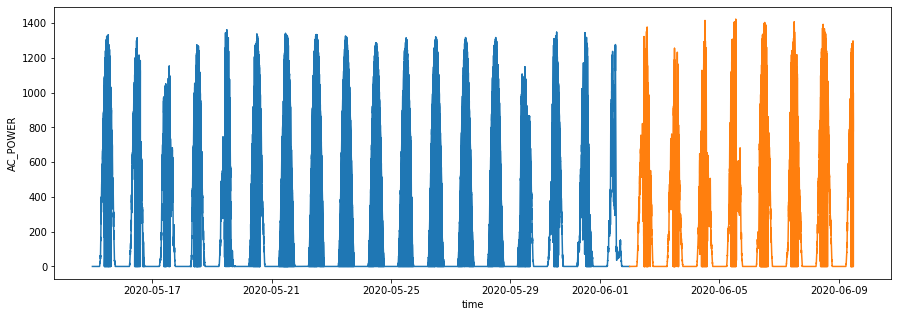

In [5]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('AC_POWER')
plt.plot(pred_train["DATE_TIME"],pred_train.DC_POWER)
plt.plot(pred_test["DATE_TIME"],pred_test.DC_POWER)
plt.show()

In [6]:
import numpy as np
train_features = ['HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
predict_column = 'AC_POWER'
prediction_models = []
for source_key in np.arange(0,len(unique_source_keys),1):
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(trainSourceKeyDataFrames[source_key][train_features], trainSourceKeyDataFrames[source_key][predict_column],
        eval_set=[(trainSourceKeyDataFrames[source_key][train_features], trainSourceKeyDataFrames[source_key][predict_column]), (validSourceKeyDataFrames[source_key][train_features], validSourceKeyDataFrames[source_key][predict_column])],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False)
    prediction_models.append(reg)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

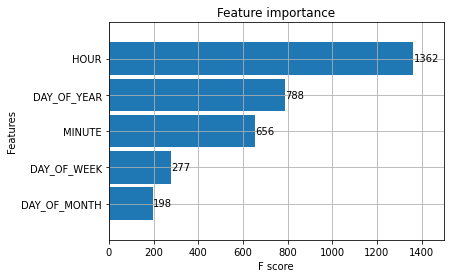

In [7]:
xgb.plot_importance(prediction_models[0], height=0.9)

In [8]:
val_predictions = []
for source_key in np.arange(0,len(unique_source_keys),1):
    val_predictions.append(prediction_models[source_key].predict(validSourceKeyDataFrames[source_key][train_features]))


In [9]:
def plot_performance(base_data, date_from, date_to, test_data, test_predictions, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy created')
    plt.plot(base_data['DATE_TIME'],base_data[predict_column], label='data')
    plt.plot(test_data['DATE_TIME'], test_predictions, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)



In [10]:
#Let's group the individual inverter predictions together every 15 mins periods
predicted_values_grouped_by_time = validSourceKeyDataFrames.copy()
df_predicted = pd.DataFrame()
df_predicted = df_predicted.append(predicted_values_grouped_by_time)
df_predicted.head(10)
df_predicted.shape

df_predicted['PREDICTED_AC_POWER'] = np.array(val_predictions).flatten()

df_predicted.head(10)
train_columns = ['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
grouped_predicted = df_predicted.groupby(train_columns)[['PREDICTED_AC_POWER','AC_POWER']].agg({'PREDICTED_AC_POWER':'sum','AC_POWER':'sum'}).reset_index()
grouped_data = train_data.groupby(train_columns)[['DC_POWER','AC_POWER']].agg({'DC_POWER':'sum','AC_POWER':'sum'}).reset_index()


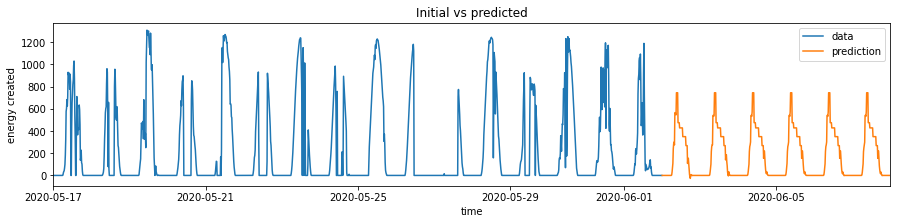

In [11]:
#Let's look at one SOURCE_KEY inverter
import datetime
pred_test_pred = reg.predict(pred_test[train_features])
plot_performance(trainSourceKeyDataFrames[1], datetime.datetime(2020,5,17) ,datetime.datetime(2020,6,8), validSourceKeyDataFrames[1], val_predictions[0],'Initial vs predicted')
plt.legend()
plt.show()


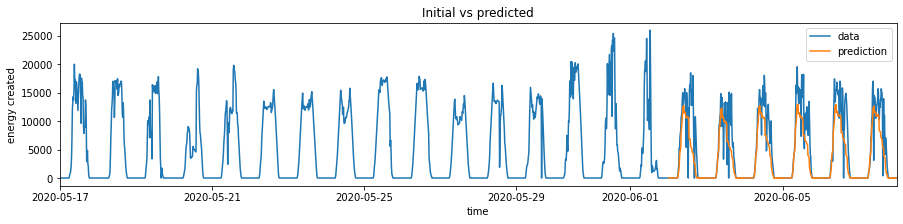

In [12]:
#lets see how all inverters validation part looks like
import datetime
plot_performance(grouped_data, datetime.datetime(2020,5,17) ,datetime.datetime(2020,6,8), grouped_predicted, grouped_predicted['PREDICTED_AC_POWER'],'Initial vs predicted')
plt.legend()
plt.show()


In [13]:
test_data = pd.read_csv('../Data/Test_Plant2.csv')
create_features(test_data)
testSourceKeyDataFrames = [test_data[test_data.SOURCE_KEY == t] for t in unique_source_keys]
test_predictions = []
for source_key in np.arange(0,len(unique_source_keys),1):
    test_predictions.append(prediction_models[source_key].predict(testSourceKeyDataFrames[source_key][train_features]))

test_values_grouped_by_time = testSourceKeyDataFrames.copy()
df_testPredicted = pd.DataFrame()
df_testPredicted = df_testPredicted.append(test_values_grouped_by_time)
df_testPredicted['PREDICTED_AC_POWER'] = np.array(test_predictions).flatten()

train_columns = ['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
grouped_testPredicted = df_testPredicted.groupby(train_columns)[['PREDICTED_AC_POWER','AC_POWER']].agg({'PREDICTED_AC_POWER':'sum','AC_POWER':'sum'}).reset_index()
grouped_testData = test_data.groupby(train_columns)[['DC_POWER','AC_POWER']].agg({'DC_POWER':'sum','AC_POWER':'sum'}).reset_index()

test_mse = mean_squared_error(y_true=grouped_testData[predict_column],
                   y_pred=grouped_testPredicted['PREDICTED_AC_POWER'])
print('MSE:',test_mse)

MSE: 10075428.864699142


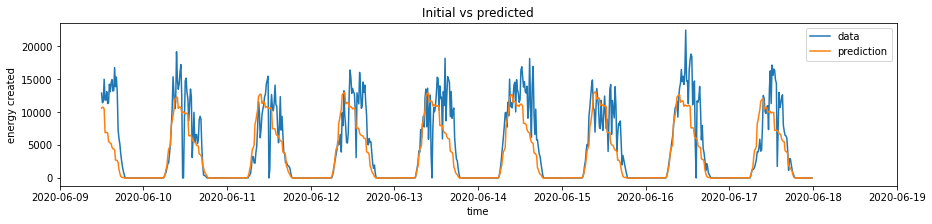

In [14]:
plot_performance(grouped_testData, datetime.datetime(2020,6,9) ,datetime.datetime(2020,6,19),grouped_testPredicted,grouped_testPredicted['PREDICTED_AC_POWER'],'Initial vs predicted')


Plant 2
Test run on 24.11.2020 23:16
Features:
['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
Predicted:
AC_POWER
MSE: 10075428.864699142

Plant 1
Test run on 24.11.2020 22:06
Features:
['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
Predicted:
AC_POWER
['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
MSE: 56401147.729584105
